In [1]:
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pdb
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [2]:
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
from torchvision import datasets
from torchvision import transforms as trans

from pathlib import Path
from models.yolo_body_res50 import Yolo_body
import numpy as np
# np.seterr(all='raise')
import torch
from torch import nn, optim
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
from utils.vis_utils import *
from utils.box_utils import *
from utils.dataset_tools import *
from utils.utils import *
from models.Yolo_head import Yolo_loss
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook
from imgaug import augmenters as iaa
from Yolo_trainer import Yolo

In [3]:
conf = edict()

conf.coco_anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                     [59, 119], [116, 90], [156, 198], [373, 326]]
conf.train_path = Path('/home/f/nvme/coco2017/train2017/')
conf.train_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_train2017.json')
conf.val_path = Path('/home/f/nvme/coco2017/val2017/')
conf.val_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_val2017.json')
conf.log_path = Path('/home/f/learning/yolo/log')
conf.model_path = Path('/home/f/learning/yolo/model')
conf.save_path = Path('/home/f/learning/yolo/save')

conf.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from pycocotools.coco import COCO

In [5]:
conf.train_anno_path

PosixPath('/home/f/nvme/coco2017/annotations/instances_train2017.json')

In [6]:
coco=COCO(conf.train_anno_path)

loading annotations into memory...
Done (t=9.55s)
creating index...
index created!


In [7]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

In [8]:
nms=[cat['name'] for cat in cats]

In [9]:
nms

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [ ]:
print('COCO categories: \n{}\n'.format(' '.join(nms)))

In [11]:
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO supercategories: 
person outdoor animal accessory appliance sports vehicle furniture electronic food indoor kitchen


In [20]:
a

[17]

In [10]:
# get all images containing given categories, select one at random
coco.getCatIds(catNms=['cat']);

In [11]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);

In [22]:
catIds

[1, 18, 41]

In [16]:
imgIds = coco.getImgIds(catIds=catIds );

In [13]:
imgIds = coco.getImgIds(imgIds = [324158])

In [17]:
imgIds

[379520,
 55809,
 46978,
 438915,
 500100,
 209028,
 89350,
 341623,
 306440,
 76937,
 372874,
 22796,
 282768,
 360595,
 366484,
 410005,
 172310,
 449560,
 557721,
 22427,
 365340,
 363549,
 354721,
 47909,
 125351,
 312233,
 28842,
 304173,
 241837,
 560561,
 88754,
 429236,
 536244,
 380724,
 55478,
 23737,
 377278,
 411583,
 476736,
 461632,
 463044,
 569158,
 102599,
 231240,
 296782,
 48595,
 558036,
 518613,
 441470,
 493020,
 297692,
 162396,
 547421,
 176229,
 392166,
 251368,
 255209,
 353644,
 155117,
 551795,
 556149,
 45175,
 568187,
 158718,
 575615]

In [35]:
len(imgIds)

1

In [18]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [19]:
img

{'license': 2,
 'file_name': '000000366484.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000366484.jpg',
 'height': 640,
 'width': 480,
 'date_captured': '2013-11-18 10:54:26',
 'flickr_url': 'http://farm3.staticflickr.com/2359/5728986765_2f3263935e_z.jpg',
 'id': 366484}

In [20]:
img['coco_url']

'http://images.cocodataset.org/train2017/000000366484.jpg'

In [21]:
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

URLError: <urlopen error [Errno 99] Cannot assign requested address>

In [ ]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')

In [22]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

In [23]:
annIds

[3643, 198962, 640246, 1715388]

In [24]:
anns = coco.loadAnns(annIds)

In [50]:
anns[0]

{'segmentation': [[388.15,
   191.81,
   303.77,
   207.38,
   271.32,
   209.98,
   258.34,
   207.38,
   244.06,
   163.25,
   253.14,
   145.07,
   277.81,
   123.0,
   299.88,
   113.91,
   316.75,
   112.62,
   342.72,
   113.91,
   355.7,
   123.0,
   369.98,
   125.6,
   408.92,
   150.26,
   408.92,
   164.54,
   399.84,
   182.72]],
 'area': 11877.610150000002,
 'iscrowd': 0,
 'image_id': 366484,
 'bbox': [244.06, 112.62, 164.86, 97.36],
 'category_id': 18,
 'id': 3643}

In [44]:
m = coco.annToMask(anns[0])

In [49]:
(m * 255)[200]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

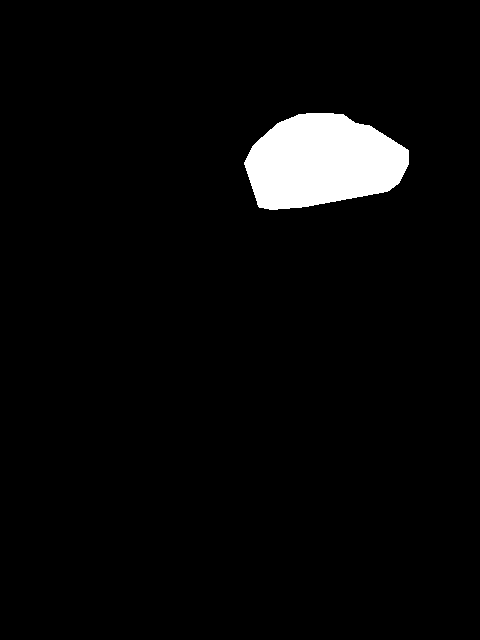

In [45]:
Image.fromarray(m * 255)

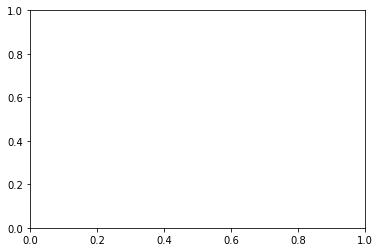

In [49]:
coco.showAnns(anns)

In [ ]:
# train_dataset = datasets.CocoDetection(conf.train_path, conf.train_anno_path)
coco_class_2_id, coco_id_2_class = get_coco_class_name_map(
    conf.train_anno_path)
conf.class_num = len(coco_id_2_class)

id_2_correct_id = {}
correct_id_2_id = {}
id_2_correct_id = dict(zip(coco_id_2_class.keys(), range(80)))
correct_id_2_id = dict(zip(range(80), coco_id_2_class.keys()))

correct_id_2_class = {}
class_2_correct_id = {}
for k, v in coco_id_2_class.items():
    correct_id_2_class[id_2_correct_id[k]] = v
    class_2_correct_id[v] = id_2_correct_id[k]

train_dataset.maps = [
    id_2_correct_id, correct_id_2_id, correct_id_2_class, class_2_correct_id
]

id_2_correct_id = {}
correct_id_2_id = {}
id_2_correct_id = dict(zip(coco_id_2_class.keys(), range(80)))
correct_id_2_id = dict(zip(range(80), coco_id_2_class.keys()))

correct_id_2_class = {}
class_2_correct_id = {}
for k, v in coco_id_2_class.items():
    correct_id_2_class[id_2_correct_id[k]] = v
    class_2_correct_id[v] = id_2_correct_id[k]

val_dataset = datasets.CocoDetection(conf.val_path, conf.val_anno_path)
val_dataset.maps = [
    id_2_correct_id, correct_id_2_id, correct_id_2_class, class_2_correct_id
]